In [1]:
import pickle
import cv2
import json
import glob
import natsort  # natural sort (1, 2, 3, 4..., 100), instead of (1, 10, 100, 1000....)
from tqdm import tqdm

from utils.hdf5datasetwriter import HDF5DatasetWriter
from utils.aspect_aware_resize import AspectAwareResize
from utils.extract_patch import ExtractPatch

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
image_paths = natsort.natsorted(glob.glob("train/*.png"))

metadata = pickle.load(open("pkl/metadata.pkl", "rb"))
labels = pickle.load(open("pkl/svhn_labels.pkl", "rb"))

print(image_paths[:10])
print(" ")
print(metadata[:10])
print(" ")
print(labels[:10])

['train/1.png', 'train/2.png', 'train/3.png', 'train/4.png', 'train/5.png', 'train/6.png', 'train/7.png', 'train/8.png', 'train/9.png', 'train/10.png']
 
[{'label': [1, 9], 'top': [77, 81], 'left': [246, 323], 'height': [219, 219], 'width': [81, 96]}, {'label': [2, 3], 'top': [29, 25], 'left': [77, 98], 'height': [32, 32], 'width': [23, 26]}, {'label': [2, 5], 'top': [5, 5], 'left': [17, 25], 'height': [15, 15], 'width': [8, 9]}, {'label': [9, 3], 'top': [13, 13], 'left': [57, 72], 'height': [34, 34], 'width': [15, 13]}, {'label': [3, 1], 'top': [7, 10], 'left': [52, 74], 'height': [46, 46], 'width': [21, 15]}, {'label': [3, 3], 'top': [6, 8], 'left': [28, 38], 'height': [21, 21], 'width': [10, 11]}, {'label': [2, 8], 'top': [10, 11], 'left': [35, 47], 'height': [32, 32], 'width': [13, 13]}, {'label': [7, 4, 4], 'top': [4, 4, 3], 'left': [17, 25, 31], 'height': [15, 15, 15], 'width': [7, 6, 7]}, {'label': [1, 2, 8], 'top': [4, 4, 5], 'left': [19, 29, 38], 'height': [24, 24, 24], 'width

## Quick look at the data

In [3]:
def draw_bbox(img, metadata):
    x = int(min(metadata["left"]))
    y = int(min(metadata["top"]))
    w = int(metadata["left"][-1] + metadata["width"][-1])
    h = int(max(metadata["top"]) + max(metadata["height"]))
    
    return cv2.rectangle(img.copy(), (x,y), (w, h), (0,255,0), 2)

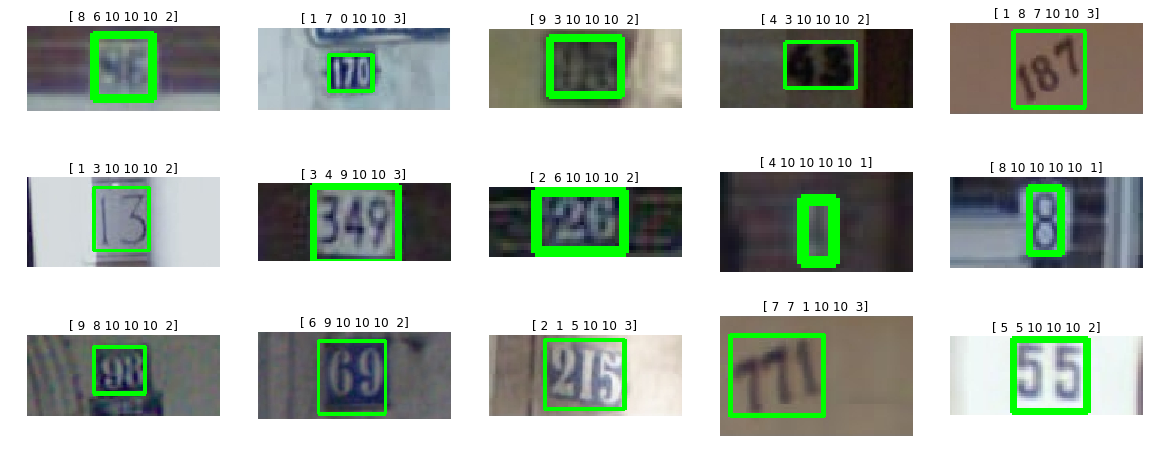

In [4]:
plt.figure(figsize=(20, 8))

for idx, i in enumerate(range(12500, 12515)):
    img = cv2.imread(image_paths[i])
    md = metadata[i]
    
    bb = draw_bbox(img, md)
    
    plt.subplot(3, 5, idx+1)
    plt.title(labels[i])
    plt.imshow(cv2.cvtColor(bb, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    
plt.show()    

## Preprocessing the images as described in the paper

 1. Expand bounding box by 30% in both x, y directions.
 2. Crop the image to that bounding box and resize it to 64x64.

In [5]:
def crop_bbox(img, metadata):
    shape = img.shape[:2]
    
    x = int(min(metadata["left"]))
    y = int(min(metadata["top"]))
    w = int(metadata["left"][-1] + metadata["width"][-1])
    h = int(max(metadata["top"]) + max(metadata["height"]))
    
    dW = int(0.15*(w-x))
    dH = int(0.15*(h-y))
    
    x = 0 if (x - dW) < 0 else (x - dW)
    y = 0 if (y - dH) < 0 else (y - dH)
    w = shape[1] if (w + dW) > shape[1] else (w + dW)
    h = shape[0] if (h + dH) > shape[0] else (h + dH)
    
    cropped = img[y:h, x:w]
    
    return cv2.resize(cropped, (64, 64))

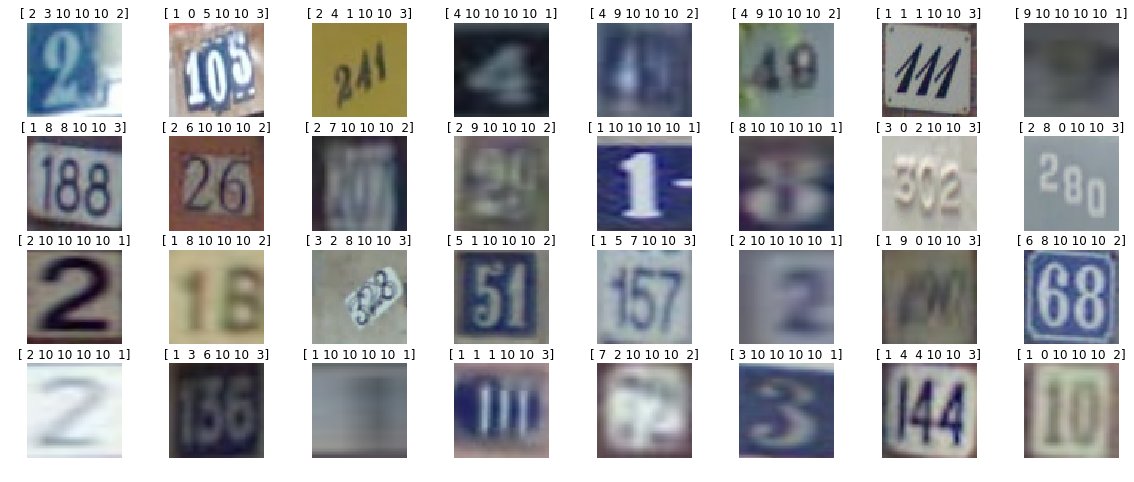

In [6]:
plt.figure(figsize=(20, 8))

for idx, i in enumerate(range(200, 232)):
    img = cv2.imread(image_paths[i])
    md = metadata[i]
    
    bb = crop_bbox(img, md)
    
    plt.subplot(4, 8, idx+1)
    plt.title(labels[i])
    plt.imshow(cv2.cvtColor(bb, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    
plt.show()  

To increase the size of dataset, a 54x54 patch is cropped from the 64x64 image to feed into the model, let's see how it the 54x54 patch looks like

/home/yq/miniconda3/envs/tf/lib/python3.6/site-packages/sklearn/feature_extraction/image.py:287: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  indexing_strides = arr[slices].strides


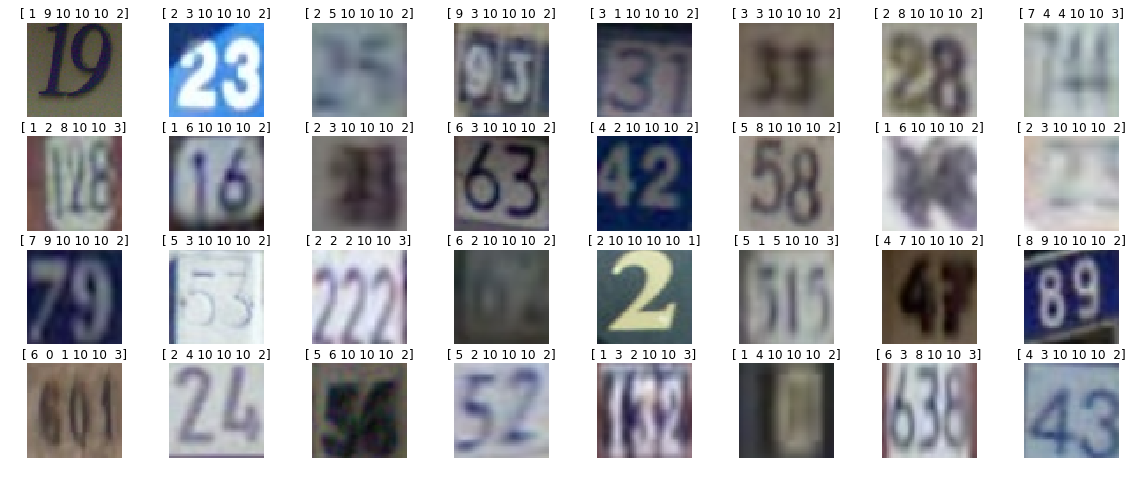

In [7]:
ep = ExtractPatch(54, 54)

plt.figure(figsize=(20, 8))

for idx, i in enumerate(range(32)):
    img = cv2.imread(image_paths[i])
    md = metadata[i]
    
    bb = crop_bbox(img, md)
    bb = ep.preprocess(bb)
    
    plt.subplot(4, 8, idx+1)
    plt.title(labels[i])
    plt.imshow(cv2.cvtColor(bb, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    
plt.show()  

### Write the 64x64 images into HDF5 file

At the same time, compute the means for each color channels to be used later.

In [8]:
# prepare the test set as well
test_paths = natsort.natsorted(glob.glob("test/*.png"))

test_metadata = pickle.load(open("pkl/metadata_test.pkl", "rb"))
test_labels = pickle.load(open("pkl/svhn_labels_test.pkl", "rb"))

In [9]:
# split training set into training and validation set

Ptr, ytr, metatr = image_paths[:-2500], labels[:-2500], metadata[:-2500]
Pval, yval, metaval = image_paths[-2500:], labels[-2500:], metadata[-2500:]

In [10]:
datasets = [("train", Ptr, ytr, metatr, "hdf5/train.hdf5"),
           ("val", Pval, yval, metaval, "hdf5/val.hdf5"),
            ("test", test_paths, test_labels, test_metadata, "hdf5/test.hdf5")]

R, G, B = [], [], []

for (dtype, paths, labels, metas, outputs) in datasets:
    writer = HDF5DatasetWriter((len(paths), 64, 64, 3), outputs)
    
    t = tqdm(zip(paths, labels, metas))
    for (path, label, meta) in t:
        image = cv2.imread(path)
        image = crop_bbox(image, meta)
        
        if dtype == "train":
            (b, g, r) = cv2.mean(image)[:3]
            R.append(r)
            G.append(g)
            B.append(b)
            
        writer.add([image], [label])
        
    writer.close()

30902it [00:08, 3443.90it/s]
2500it [00:00, 3620.24it/s]
13068it [00:05, 2330.59it/s]


### Extra data

In [11]:
extra_path = natsort.natsorted(glob.glob("extra/*.png"))
extra_meta = pickle.load(open("pkl/metadata_extra.pkl", "rb"))
extra_labels = pickle.load(open("pkl/svhn_labels_extra.pkl", "rb"))

In [12]:
writer = HDF5DatasetWriter((len(extra_path), 64, 64, 3), "hdf5/extra_train.hdf5")

t = tqdm(zip(extra_path, extra_labels, extra_meta))
for (path, label, meta) in t:
    image = cv2.imread(path)
    image = crop_bbox(image, meta)

    (b, g, r) = cv2.mean(image)[:3]
    R.append(r)
    G.append(g)
    B.append(b)

    writer.add([image], [label])

writer.close()

202353it [01:12, 2792.91it/s]


In [13]:
M = {"R": np.mean(R), "G": np.mean(G), "B": np.mean(B)}
pickle.dump(M, open("rgb_means.pkl", "wb"))